In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.dates as mdates
import geopandas as gpd

## Grafici generici

In [2]:
def parse_data(s):
    s = s.split("T")[0]
    mese = s.split("-")[1]
    giorno = s.split("-")[2]
    
    return giorno + "/" + str(int(mese))

def min_max_normalization( arr):
    minv= min(arr)
    maxv= max(arr)
    arr = [(x-minv)/(maxv-minv) for x in arr]
    return arr

def create_figure():
    fig = plt.figure()
    fig.set_size_inches(20, 5)
    ax = fig.add_axes([0.1, 0.2, 0.8, 0.9]) 
    plt.xticks(rotation=45)
    return ax

def hide_ticks(ax, factor):
    for label in ax.xaxis.get_ticklabels()[::factor]:
        label.set_visible(False)  

dati = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')

giorni = list(map(parse_data, dati["data"].values))
percentages = [ str(x) + '%' for x in np.array([0.0, 25.0, 50.0, 75.0, 100.0])]


# nuovi casi
totale_casi = dati["totale_casi"].values
delta_totale_casi = [totale_casi[0]]
for g in range(len(totale_casi) - 1):
    delta_totale_casi += [totale_casi[g+1] - totale_casi[g]]
    


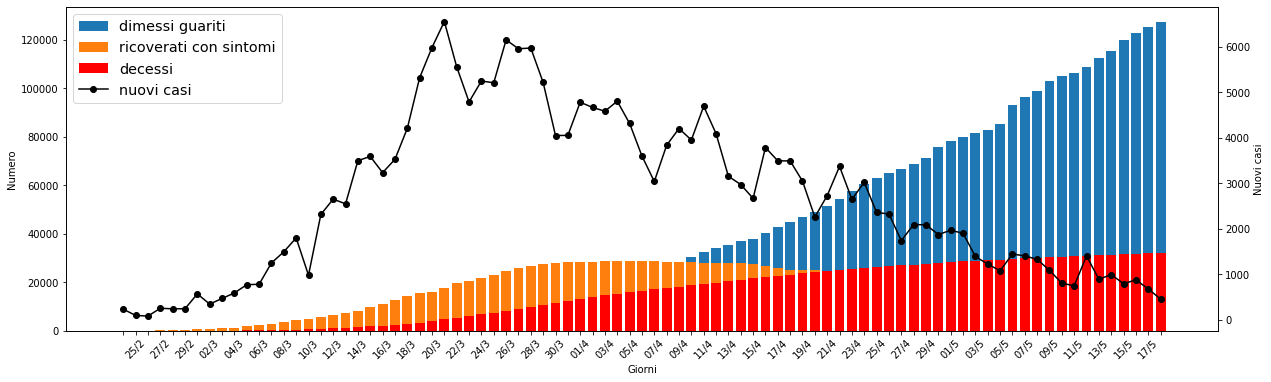

In [3]:
ax = create_figure()

ax.set_xlabel('Giorni')
ax.set_ylabel('Numero')

bar1 = ax.bar(giorni, dati['dimessi_guariti'], label='dimessi guariti')
bar2 = ax.bar(giorni, dati['ricoverati_con_sintomi'], label='ricoverati con sintomi')
bar3 = ax.bar(giorni, dati['deceduti'], label='decessi', color='r')

hide_ticks(ax, 2)

ax2 = ax.twinx()
line1 = ax2.plot(giorni, delta_totale_casi, label="nuovi casi", color="k", marker="o", linestyle="-")
ax2.set_ylabel('Nuovi casi')

arr = [bar1, bar2, bar3]+line1
labs = [a.get_label() for a in arr]
ax.legend(arr, labs, fontsize='x-large')

plt.show()

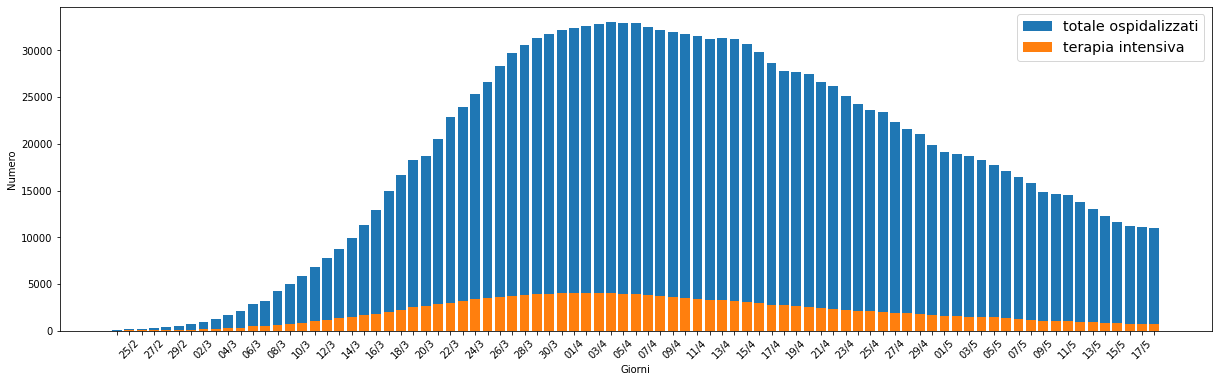

In [4]:
ax = create_figure()

ax.set_xlabel('Giorni')
ax.set_ylabel('Numero')
ax.bar(giorni, dati['totale_ospedalizzati'], label='totale ospidalizzati')
ax.bar(giorni, dati['terapia_intensiva'], label='terapia intensiva')
hide_ticks(ax, 2)
ax.legend(fontsize='x-large')

plt.show()

## Nuovi Positivi
Il primo grafico mostra i nuovi positivi in relazione ai residenti nella regione.  
Il secondo mostro i nuovi positivi effettivi in ogni regione.  
I dati dei residenti nella regione provengono da [comuni-italiani.it](http://www.comuni-italiani.it/regioni.html) che a sua volta vengono dai dati ISTAT del 2019.  

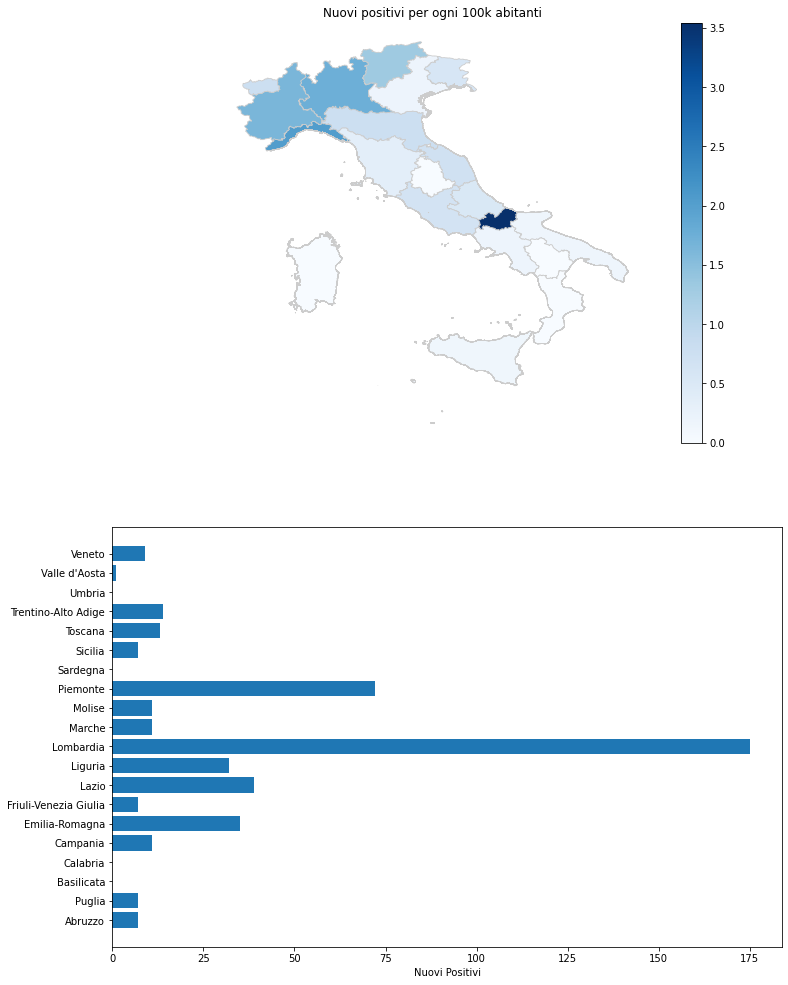

In [5]:
# Caricamento dati regioni
covid_df = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-regioni/dpc-covid19-ita-regioni-latest.csv')
covid_df = covid_df.replace(to_replace={'P.A. Bolzano': 'Trentino-Alto Adige', 'P.A. Trento': 'Trentino-Alto Adige', 
                                       'Friuli Venezia Giulia': 'Friuli-Venezia Giulia'}) \
                    .groupby('denominazione_regione', as_index=False) \
                    .sum(numeric_only=True)

# Caricamento della shape dell'Italia
fp = "datasets/italy shape/ITA_adm1.shp"
map_df = gpd.read_file(fp)
map_df = map_df.replace(to_replace={'Apulia': 'Puglia', 'Sicily': 'Sicilia'})

# Caricamento dataset della popolazione italiana
popolazione = pd.read_csv('datasets/popolazione_italiana.csv', thousands='.')

# Unione dei tre dataset
merged = map_df.merge(covid_df, how='left', left_on="NAME_1", right_on="denominazione_regione") \
                .merge(popolazione, how='left', left_on="NAME_1", right_on='Regione')

# Tenere solo le colonne utili
merged = merged[[ 'Regione', 'nuovi_positivi', 'Residenti', 'geometry']]

# Normalizzazione dei nuovi positivi per ogni 100k abitanti
div = lambda x: x[0]*100000/x[1] if 0<(x[0]/x[1])<1 else 0
merged['nuovi_positivi_normalizzati'] = list(map(div, zip(merged['nuovi_positivi'], merged['Residenti']))) 

# Print figura
fig, ax = plt.subplots(2, figsize=(12, 17))
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=max(merged['nuovi_positivi_normalizzati'])))
fig.colorbar(sm, ax=ax[0], orientation='vertical')

ax[0].axis('off')
ax[0].set_title('Nuovi positivi per ogni 100k abitanti', fontdict={'fontsize': '12', 'fontweight' : '3'})

# create map
merged.plot(column='nuovi_positivi_normalizzati', cmap='Blues', linewidth=0.8, ax=ax[0], edgecolor='0.8')

ax[1].barh( merged.index.values, merged['nuovi_positivi'].values, label='nuovi positivi', tick_label=merged['Regione'])
ax[1].set_xlabel('Nuovi Positivi')

plt.show()
#plt.tight_layout()

## Tamponi e nuovi  casi
Grafico che mette in relazione i nuovi casi con i tamponi giornalieri fatti.  

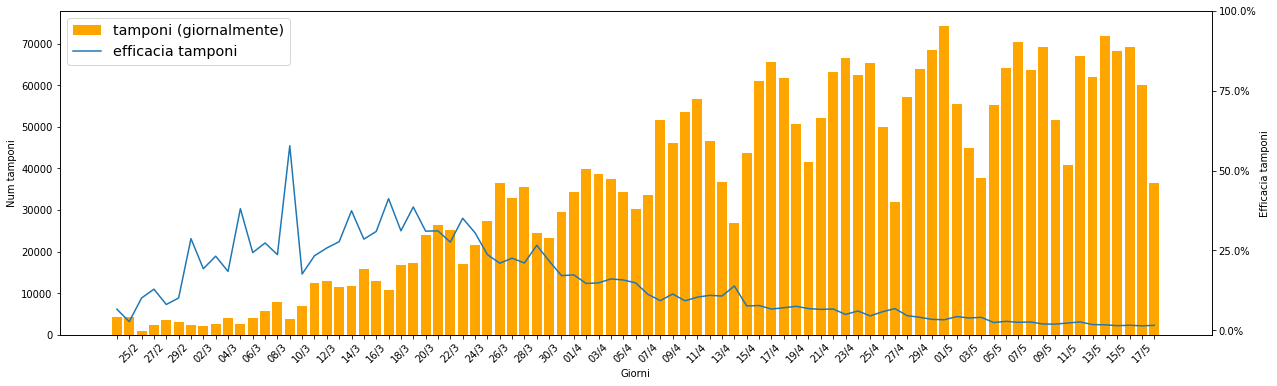

In [6]:
# nuovi tamponi giornalieri
numero_tamponi = dati["tamponi"].values
delta_tamponi = [numero_tamponi[0]]
for g in range(len(numero_tamponi) - 1):
    delta_tamponi += [numero_tamponi[g+1] - numero_tamponi[g]]
ax = create_figure()

# percentuale nuovi_positivi/nuovi_tamponi
div = lambda x: x[0]/x[1] if 0<(x[0]/x[1])<1 else None
ratio_nuovi_pos_nuovi_tamp = list(map(div, list(zip(delta_totale_casi, delta_tamponi))))

ax.set_xlabel('Giorni')
ax.set_ylabel('Percentuale')

bar = ax.bar(giorni, delta_tamponi, label="tamponi (giornalmente)", color="orange")
hide_ticks(ax, 2)

# double y axis
ax2 = ax.twinx()
line_positivi = ax2.plot(giorni, ratio_nuovi_pos_nuovi_tamp, label="efficacia tamponi")
ax.set_ylabel('Num tamponi')

ax2.set_yticks(np.arange(0, 1, step=0.20))
ax2.set_yticklabels(percentages)
ax2.set_ylabel('Efficacia tamponi')

arr = [bar]+line_positivi
labs = [a.get_label() for a in arr]
ax.legend(arr, labs, fontsize='x-large')

plt.show()